In [ ]:
!pip install econml==0.14.1

In [ ]:
from econml.metalearners import TLearner, SLearner, XLearner
from econml.dr import DRLearner
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
def generate_data(n, d, controls_outcome, treatment_effect, propensity):

  # 共変量の生成
  X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n) #平均が0で、共分散が単位行列である多変量正規分布から共変量を生成

  # 処置変数の生成
  T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)#各共変量に対して、propensity関数を使用し傾向スコアを計算。この確率を基に二項分布から処置変数を生成

  # 結果変数の生成
  Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X) # Y0: 処置を受けていない場合の結果
  treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
  Y = Y0 + treat_effect * T

  return (Y, T, X)

In [6]:
np.random.seed(1)
d = 10 # 10個の共変量を設定
n = 1000 # 学習データのサンプルサイズを指定(1000サンプル)
def generate_controls_outcome(d):
  beta = uniform(-2, 2, d) # 各共変量の影響を表す係数。この係数は、-2から2の間の一様分布からランダムに生成
  return lambda x: np.dot(x, beta) + normal(0, 1) # 与えられた共変量 x に対して、その共変量と係数 betaのドット積を計算し、正規分布からのノイズを加えて結果を返すラムダ関数
controls_outcome = generate_controls_outcome(d)
treatment_effect = lambda x: 10 if x[1] > 1 else (5 if x[1] > 0.1 else 0)
propensity = lambda x: (0.7 if (x[2]>-0.5 and x[2]<0.5) else 0.3)
Y, T, X = generate_data(n, d, controls_outcome, treatment_effect, propensity)

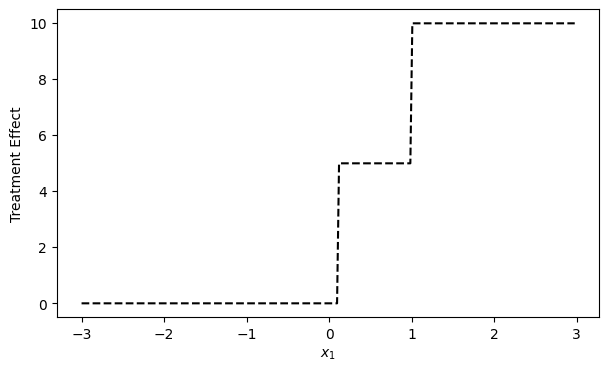

In [7]:
# 実際の処置効果の計算・可視化
n_test = 250 #テストデータのサンプルサイズを指定(250サンプル)
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test) #テストデータの共変量を生成。平均が0で共分散が単位行列である多変量正規分布からn_testサンプルを生成
delta = 6/n_test #1つ下のコードで-3から3までの範囲(全部で6)を設定しており、それをテストデータのサンプルサイズで分割
X_test[:, 1] = np.arange(-3, 3, delta) #-3から3までの範囲でdelta間隔の数値を生成
true_effects = np.array([treatment_effect(x) for x in X_test])
plt.figure(figsize=(7, 4))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test),
color='black', ls='--', label='Baseline')
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.show()

In [9]:
#ベースモデルの設定
GBR=GradientBoostingRegressor() #勾配ブースティングによる回帰クラスの設定
GBC=GradientBoostingClassifier() #勾配ブースティングによる分類クラスの設定

# モデルの初期化
models = {
    'S-Learner': SLearner(overall_model=GBR),
    'T-Learner': TLearner(models=(GBR, GBR)),
    'X-Learner': XLearner(models=(GBR, GBR)),
    'DR-Learner': DRLearner(model_regression=GBR, model_propensity=GBC)
}

# モデルの学習と評価
np.random.seed(1) # 乱数のシードを設定
results = {}
for name, model in models.items():
  model.fit(Y, T, X=X)
  preds = model.effect(X_test) # テストデータを用いてCATEを推定
  mse = mean_squared_error(true_effects, preds) # MSEを計算
  results[name] = mse
results

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


{'S-Learner': 1.2747368817967715,
 'T-Learner': 1.8033674740057357,
 'X-Learner': 0.3591869898488214,
 'DR-Learner': 9.037026078184775}

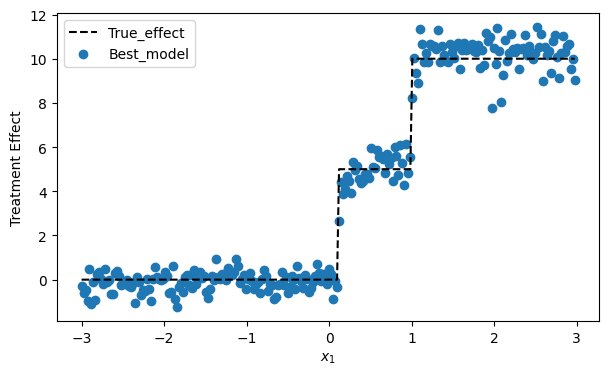

In [10]:
# 最も精度の高いモデルを選択
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

# CATEの推定結果の可視化
plt.figure(figsize=(7, 4))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test),
color='black', ls='--', label='True_effect')
plt.scatter(X_test[:, 1], best_model.effect(X_test), label="Best_model")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()